## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **NEW DATASET LOADER**

In [2]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [3]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [4]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **VIT MODEL SETUP**

In [5]:
# Attention layer
class Attention(nn.Module):
    """
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    """

    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) |
        # reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) |
        # Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Feed Forward layer
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    """
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    """

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block
class TransformerBlock(nn.Module):
    """
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    """

    def __init__(
        self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1
    ):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out


# Encoder block with multi layer
class Transformer(nn.Module):
    """
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    """

    def __init__(
        self,
        embed_dim,
        layers,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [
                TransformerBlock(
                    embed_dim, heads, activation, forward_expansion, dropout
                )
                for i in range(layers)
            ]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out


# MLP Head
class ClassificationHead(nn.Module):
    """
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    """

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out


class VisionTransformer(nn.Module):
    """
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    """

    def __init__(
        self,
        patch_size,
        max_len,
        embed_dim,
        classes,
        layers,
        channels=3,
        heads=8,
        activation=None,
        forward_expansion=1,
        dropout=0.1,
    ):
        super(VisionTransformer, self).__init__()
        self.name = "VisionTransformer"
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(
            embed_dim, layers, heads, activation, forward_expansion, dropout
        )
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        # Split image into small patch
        out = (
            inp.unfold(2, self.patch_size, self.patch_size)
            .unfold(3, self.patch_size, self.patch_size)
            .contiguous()
        )
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) |
        # seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        # Flatten patch into 1 dimension
        out = out.reshape(batch_size, seq_len, -1)
        # Mapping from patch 1 dimension to hidden embedding dimension
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        # Add class token to head of embedding vector
        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[: seq_len + 1]
        position_embed = position_embed.unsqueeze(0).expand(
            batch_size, seq_len + 1, self.embed_dim
        )
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [6]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [7]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 4
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 12
heads = 12

resnet_features_channels = 64

In [8]:
# Init model
model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads,
).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [9]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:02<00:00, 79470232.74it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [11]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_patch4-768d-12h-12l_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_patch4-768d-12h-12l_CIFAR100.pt",
)


# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


Epoch : 1 - acc: 0.0868 - loss : 4.0389



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.1397 - test loss : 3.7335



100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s]


Epoch : 2 - acc: 0.1435 - loss : 3.6587



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.1753 - test loss : 3.4822



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 3 - acc: 0.1774 - loss : 3.4474



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.1962 - test loss : 3.3207



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 4 - acc: 0.2033 - loss : 3.3014



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.2352 - test loss : 3.1794



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 5 - acc: 0.2231 - loss : 3.1770



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.2491 - test loss : 3.0857



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 6 - acc: 0.2423 - loss : 3.0839



100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


test acc: 0.2568 - test loss : 3.0192



100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s]


Epoch : 7 - acc: 0.2529 - loss : 3.0093



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.2694 - test loss : 2.9502



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 8 - acc: 0.2681 - loss : 2.9379



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.2721 - test loss : 2.9172



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 9 - acc: 0.2806 - loss : 2.8767



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.2890 - test loss : 2.8708



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 10 - acc: 0.2928 - loss : 2.8190



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3006 - test loss : 2.8456



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 11 - acc: 0.3007 - loss : 2.7698



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3045 - test loss : 2.8124



100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s]


Epoch : 12 - acc: 0.3104 - loss : 2.7263



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3126 - test loss : 2.7925



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 13 - acc: 0.3187 - loss : 2.6844



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3184 - test loss : 2.7349



100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s]


Epoch : 14 - acc: 0.3273 - loss : 2.6472



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3253 - test loss : 2.7075



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 15 - acc: 0.3368 - loss : 2.6024



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3291 - test loss : 2.6938



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 16 - acc: 0.3444 - loss : 2.5636



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3411 - test loss : 2.6492



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 17 - acc: 0.3486 - loss : 2.5298



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3357 - test loss : 2.6566



100%|██████████| 1563/1563 [04:31<00:00,  5.76it/s]


Epoch : 18 - acc: 0.3558 - loss : 2.4955



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3402 - test loss : 2.6226



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 19 - acc: 0.3627 - loss : 2.4653



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3368 - test loss : 2.6358



100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s]


Epoch : 20 - acc: 0.3686 - loss : 2.4320



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3438 - test loss : 2.6224



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 21 - acc: 0.3734 - loss : 2.4114



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3524 - test loss : 2.5824



100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s]


Epoch : 22 - acc: 0.3808 - loss : 2.3837



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3503 - test loss : 2.5934



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 23 - acc: 0.3873 - loss : 2.3488



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3526 - test loss : 2.5919



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 24 - acc: 0.3889 - loss : 2.3305



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3545 - test loss : 2.5809



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 25 - acc: 0.3962 - loss : 2.3018



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3622 - test loss : 2.5624



100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s]


Epoch : 26 - acc: 0.3988 - loss : 2.2892



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3578 - test loss : 2.5745



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 27 - acc: 0.4071 - loss : 2.2552



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3706 - test loss : 2.5540



100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s]


Epoch : 28 - acc: 0.4097 - loss : 2.2279



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3702 - test loss : 2.5303



100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s]


Epoch : 29 - acc: 0.4173 - loss : 2.2049



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3722 - test loss : 2.5211



100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s]


Epoch : 30 - acc: 0.4217 - loss : 2.1801



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3725 - test loss : 2.5283



100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s]


Epoch : 31 - acc: 0.4250 - loss : 2.1608



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3770 - test loss : 2.5207



100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s]


Epoch : 32 - acc: 0.4329 - loss : 2.1378



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3820 - test loss : 2.4988



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 33 - acc: 0.4338 - loss : 2.1217



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3754 - test loss : 2.5209



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 34 - acc: 0.4395 - loss : 2.1162



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3763 - test loss : 2.5156



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 35 - acc: 0.4389 - loss : 2.0878



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3792 - test loss : 2.5234



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 36 - acc: 0.4484 - loss : 2.0585



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3834 - test loss : 2.5150



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 37 - acc: 0.4514 - loss : 2.0491



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3743 - test loss : 2.5466



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 38 - acc: 0.4554 - loss : 2.0266



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3768 - test loss : 2.5281



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 39 - acc: 0.4578 - loss : 2.0127



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3871 - test loss : 2.4869



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 40 - acc: 0.4625 - loss : 1.9892



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3811 - test loss : 2.5159



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 41 - acc: 0.4667 - loss : 1.9701



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3803 - test loss : 2.5334



100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s]


Epoch : 42 - acc: 0.4719 - loss : 1.9484



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3789 - test loss : 2.5513



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 43 - acc: 0.4726 - loss : 1.9461



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3835 - test loss : 2.5233



100%|██████████| 1563/1563 [04:30<00:00,  5.77it/s]


Epoch : 44 - acc: 0.4787 - loss : 1.9154



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3828 - test loss : 2.5320



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 45 - acc: 0.4783 - loss : 1.9069



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3835 - test loss : 2.5197



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 46 - acc: 0.4848 - loss : 1.8909



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3733 - test loss : 2.5407



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 47 - acc: 0.4884 - loss : 1.8707



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3826 - test loss : 2.5554



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 48 - acc: 0.4896 - loss : 1.8616



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3836 - test loss : 2.5358



100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s]


Epoch : 49 - acc: 0.4958 - loss : 1.8413



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3917 - test loss : 2.5348



100%|██████████| 1563/1563 [04:30<00:00,  5.78it/s]


Epoch : 50 - acc: 0.4986 - loss : 1.8187



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3842 - test loss : 2.5312



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 51 - acc: 0.5042 - loss : 1.8060



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3885 - test loss : 2.5370



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 52 - acc: 0.5035 - loss : 1.8102



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3920 - test loss : 2.5331



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 53 - acc: 0.5087 - loss : 1.7802



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3924 - test loss : 2.5418



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 54 - acc: 0.5148 - loss : 1.7540



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3895 - test loss : 2.5449



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 55 - acc: 0.5169 - loss : 1.7390



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3862 - test loss : 2.5517



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 56 - acc: 0.5209 - loss : 1.7273



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3870 - test loss : 2.5649



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 57 - acc: 0.5223 - loss : 1.7143



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3891 - test loss : 2.5578



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 58 - acc: 0.5252 - loss : 1.6992



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3868 - test loss : 2.5533



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 59 - acc: 0.5296 - loss : 1.6801



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3871 - test loss : 2.5744



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 60 - acc: 0.5302 - loss : 1.6781



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3837 - test loss : 2.6188



100%|██████████| 1563/1563 [04:30<00:00,  5.79it/s]


Epoch : 61 - acc: 0.5327 - loss : 1.6628



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3922 - test loss : 2.5658



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 62 - acc: 0.5426 - loss : 1.6234



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3935 - test loss : 2.5793



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 63 - acc: 0.5428 - loss : 1.6261



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3906 - test loss : 2.5721



100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s]


Epoch : 64 - acc: 0.5453 - loss : 1.6186



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3897 - test loss : 2.6028



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 65 - acc: 0.5460 - loss : 1.6158



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3855 - test loss : 2.6211



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 66 - acc: 0.5464 - loss : 1.6109



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3883 - test loss : 2.6162



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 67 - acc: 0.5500 - loss : 1.5921



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3843 - test loss : 2.6081



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 68 - acc: 0.5510 - loss : 1.5858



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3873 - test loss : 2.6122



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 69 - acc: 0.5570 - loss : 1.5709



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3970 - test loss : 2.5874



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 70 - acc: 0.5570 - loss : 1.5590



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3916 - test loss : 2.6109



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 71 - acc: 0.5629 - loss : 1.5419



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3929 - test loss : 2.6023



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 72 - acc: 0.5636 - loss : 1.5300



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3916 - test loss : 2.6325



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 73 - acc: 0.5717 - loss : 1.5088



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3869 - test loss : 2.6425



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 74 - acc: 0.5738 - loss : 1.4875



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3849 - test loss : 2.6665



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 75 - acc: 0.5777 - loss : 1.4839



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3939 - test loss : 2.6297



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 76 - acc: 0.5800 - loss : 1.4686



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3889 - test loss : 2.6500



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 77 - acc: 0.5779 - loss : 1.4704



100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


test acc: 0.3874 - test loss : 2.6720



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 78 - acc: 0.5798 - loss : 1.4637



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3843 - test loss : 2.7095



100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s]


Epoch : 79 - acc: 0.5836 - loss : 1.4517



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3797 - test loss : 2.6966



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 80 - acc: 0.5812 - loss : 1.4552



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3809 - test loss : 2.7086



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 81 - acc: 0.5852 - loss : 1.4432



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3875 - test loss : 2.6904



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 82 - acc: 0.5919 - loss : 1.4227



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3901 - test loss : 2.6974



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 83 - acc: 0.5962 - loss : 1.4044



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3848 - test loss : 2.6994



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 84 - acc: 0.5967 - loss : 1.4022



100%|██████████| 313/313 [00:18<00:00, 16.48it/s]


test acc: 0.3893 - test loss : 2.7147



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 85 - acc: 0.5996 - loss : 1.3849



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3871 - test loss : 2.7202



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 86 - acc: 0.6010 - loss : 1.3773



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3958 - test loss : 2.7190



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 87 - acc: 0.6024 - loss : 1.3697



100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


test acc: 0.3880 - test loss : 2.7108



100%|██████████| 1563/1563 [04:28<00:00,  5.83it/s]


Epoch : 88 - acc: 0.6012 - loss : 1.3716



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3811 - test loss : 2.7564



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 89 - acc: 0.5996 - loss : 1.3830



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3854 - test loss : 2.7315



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 90 - acc: 0.6026 - loss : 1.3645



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3833 - test loss : 2.7834



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 91 - acc: 0.6004 - loss : 1.3693



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3899 - test loss : 2.7889



100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s]


Epoch : 92 - acc: 0.6024 - loss : 1.3668



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3772 - test loss : 2.7922



100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


Epoch : 93 - acc: 0.6013 - loss : 1.3674



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3811 - test loss : 2.7762



100%|██████████| 1563/1563 [04:29<00:00,  5.79it/s]


Epoch : 94 - acc: 0.6094 - loss : 1.3430



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3900 - test loss : 2.7870



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 95 - acc: 0.6100 - loss : 1.3393



100%|██████████| 313/313 [00:19<00:00, 16.46it/s]


test acc: 0.3826 - test loss : 2.7984



100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s]


Epoch : 96 - acc: 0.6120 - loss : 1.3391



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3854 - test loss : 2.7750



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 97 - acc: 0.6158 - loss : 1.3204



100%|██████████| 313/313 [00:19<00:00, 16.44it/s]


test acc: 0.3825 - test loss : 2.8449



100%|██████████| 1563/1563 [04:28<00:00,  5.82it/s]


Epoch : 98 - acc: 0.6207 - loss : 1.2971



100%|██████████| 313/313 [00:19<00:00, 16.45it/s]


test acc: 0.3906 - test loss : 2.8403



100%|██████████| 1563/1563 [04:28<00:00,  5.81it/s]


Epoch : 99 - acc: 0.6231 - loss : 1.2898



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3803 - test loss : 2.8154



100%|██████████| 1563/1563 [04:29<00:00,  5.81it/s]


Epoch : 100 - acc: 0.6205 - loss : 1.2983



100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


test acc: 0.3853 - test loss : 2.8289

Start Time: 1734832247.7322402
End Time: 1734861122.3179796
Time Taken: 28874.58573937416 seconds


In [12]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

<ipython-input-13-053996e4518c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


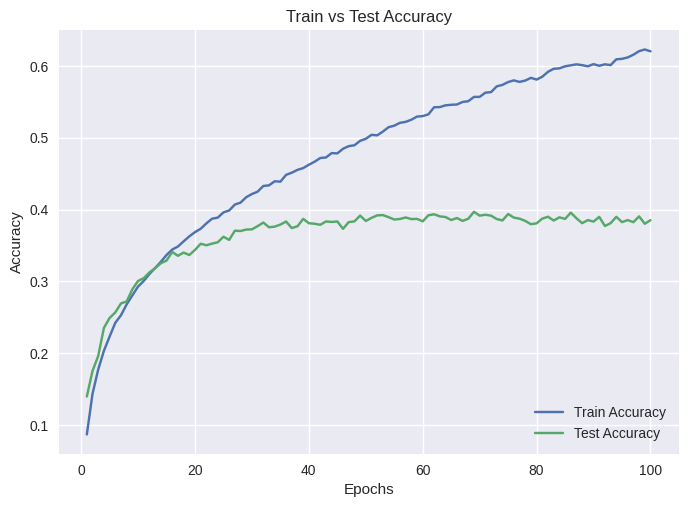

In [13]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [14]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:18<00:00, 16.97it/s]


####  Superclass confusion matrix

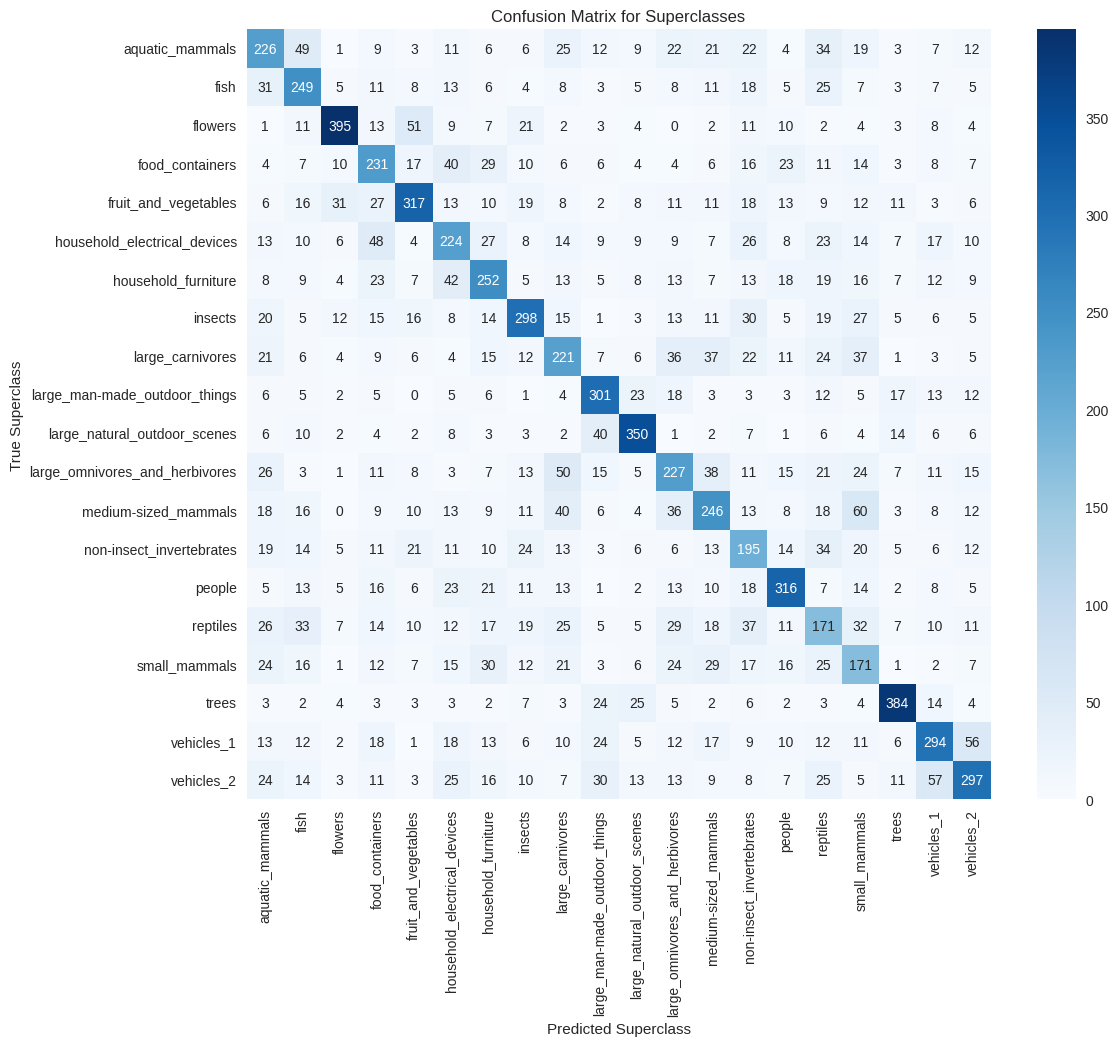

In [15]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

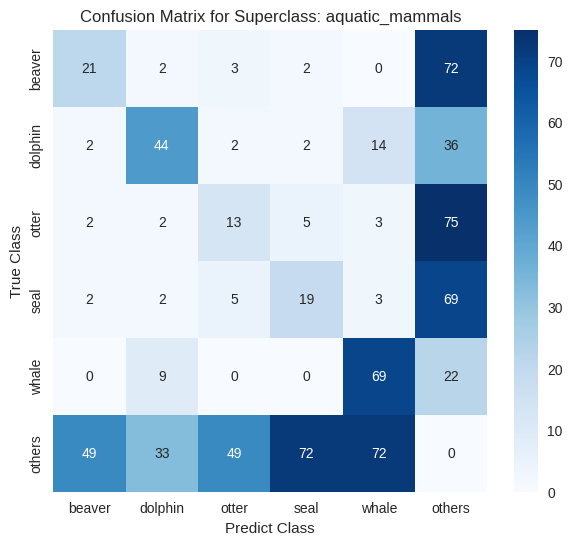

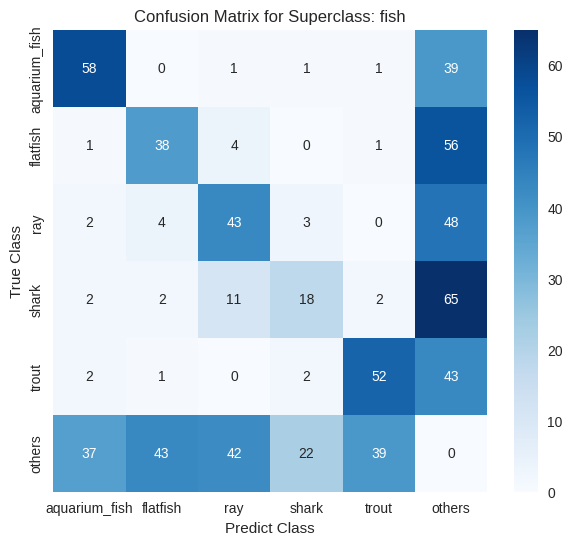

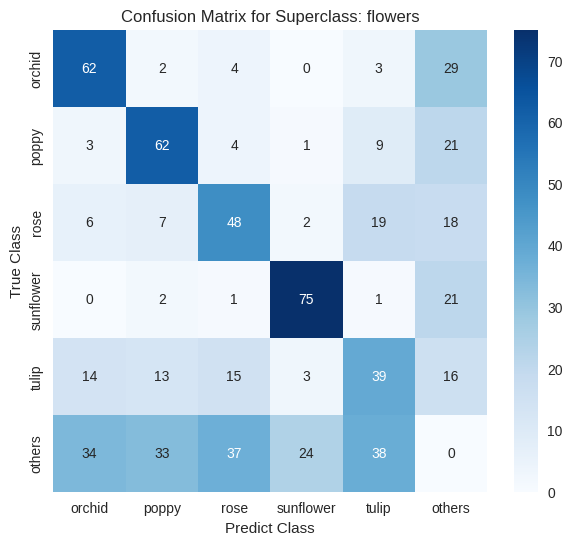

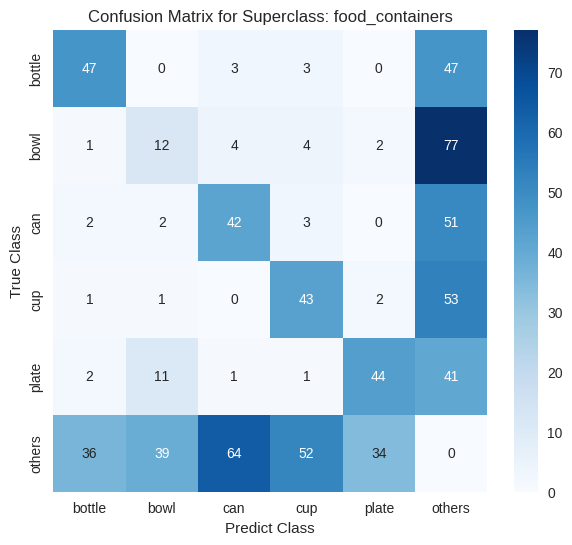

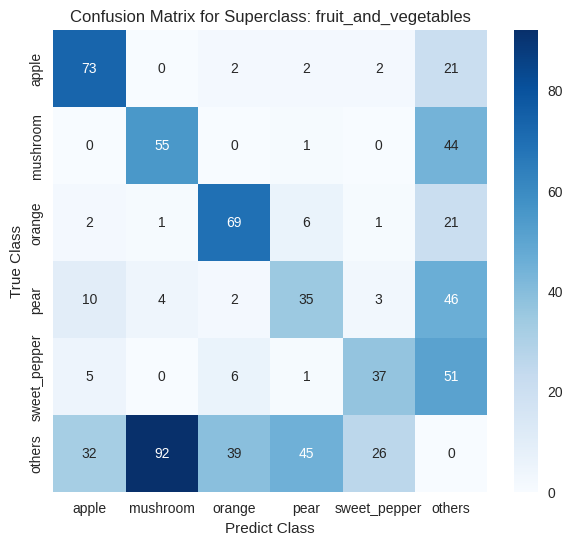

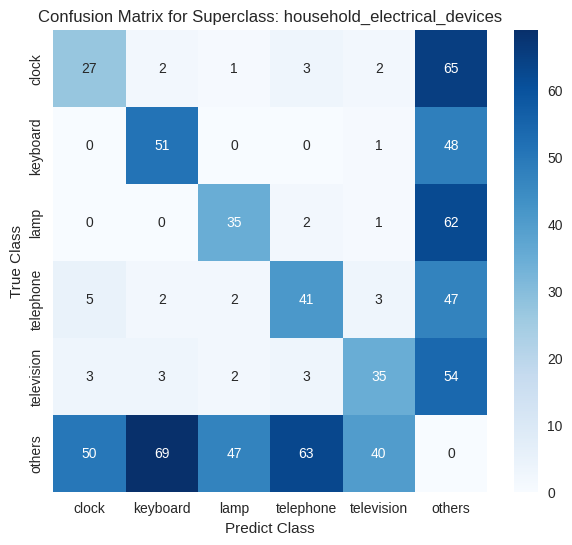

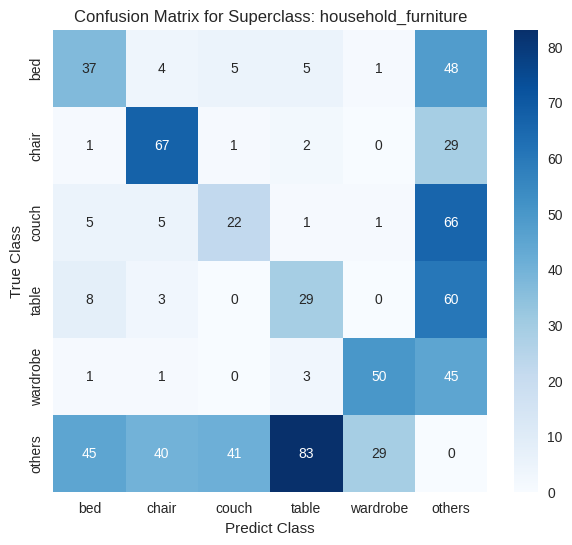

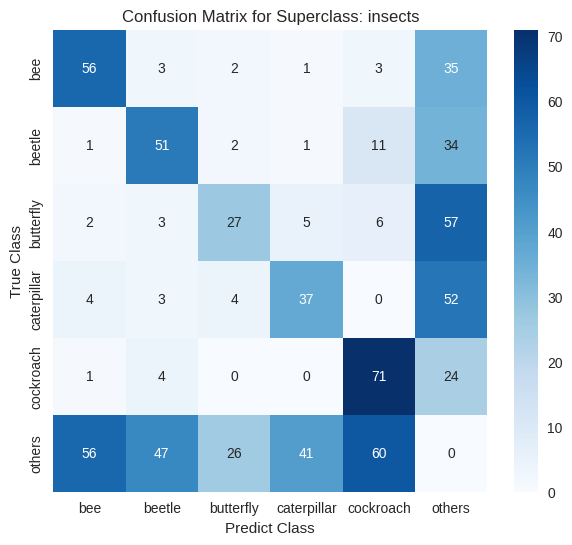

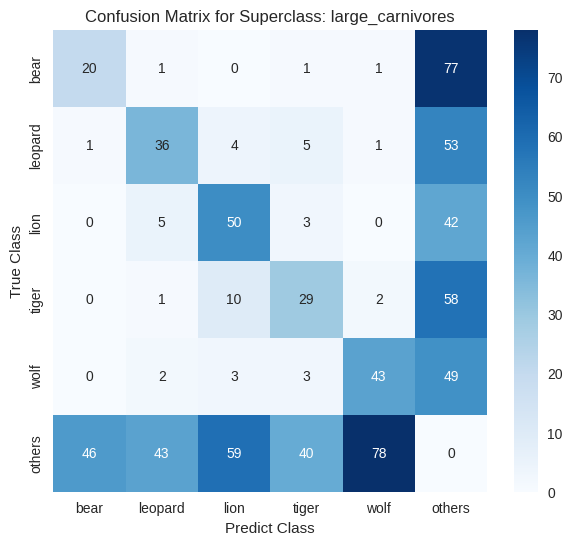

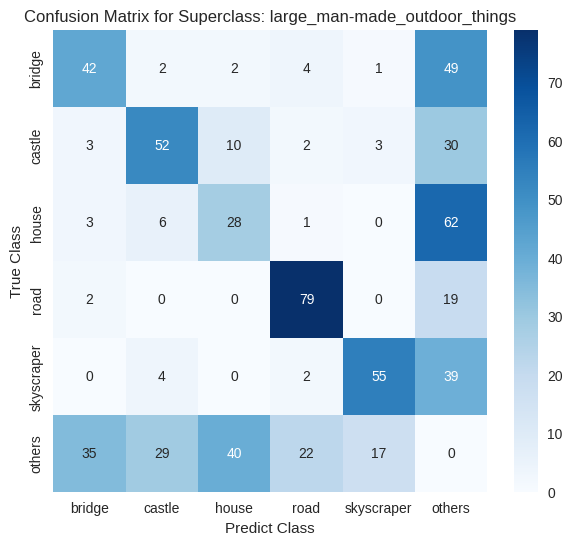

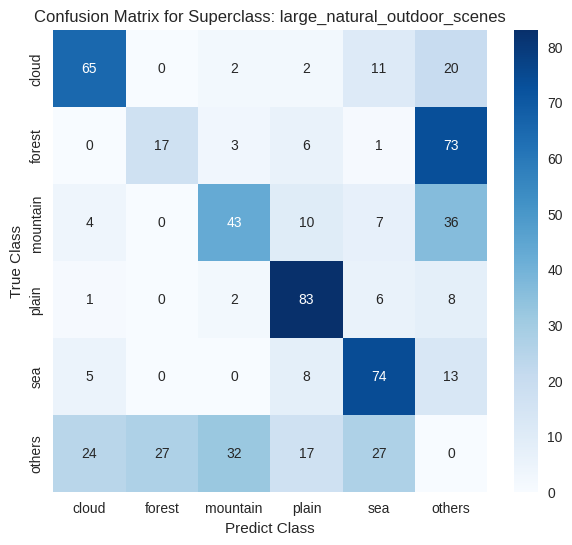

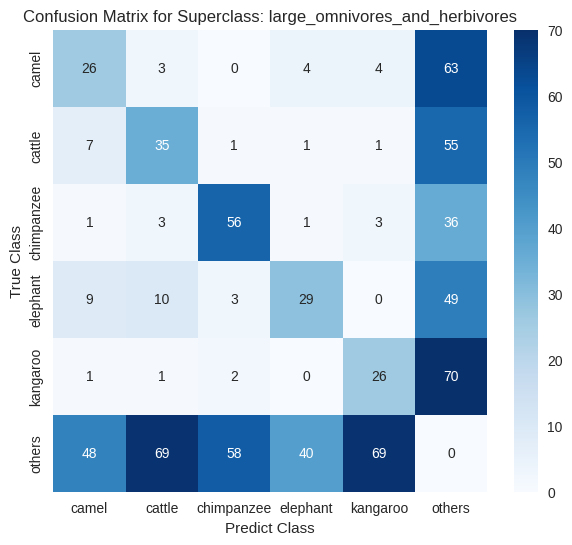

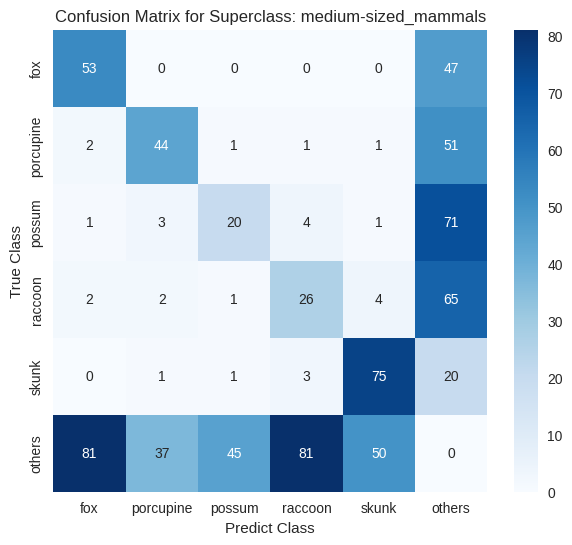

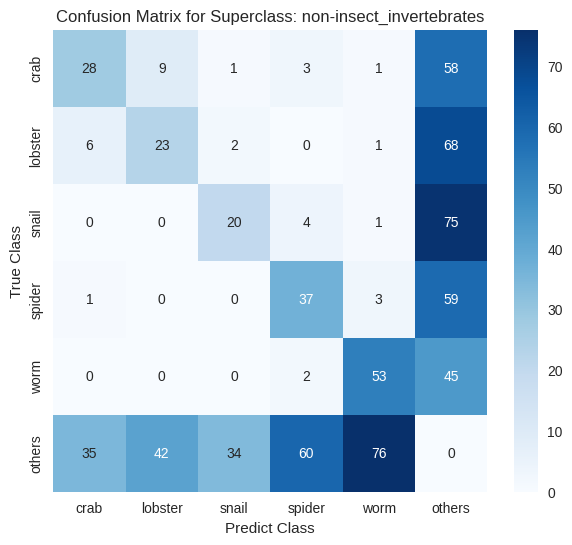

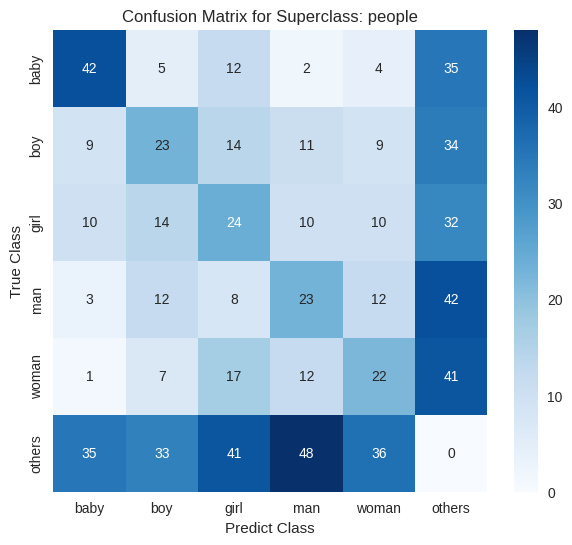

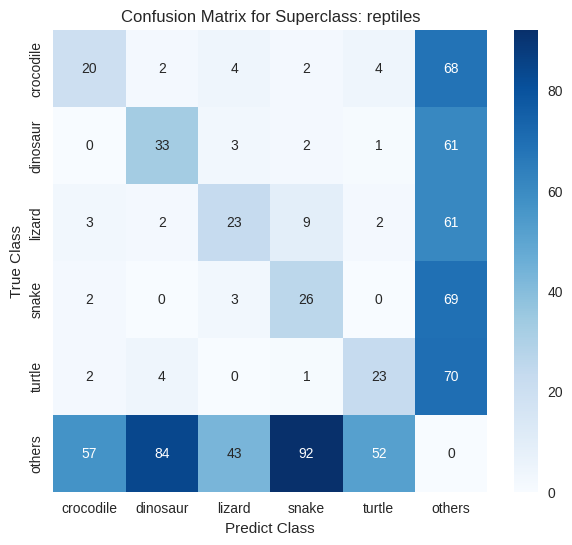

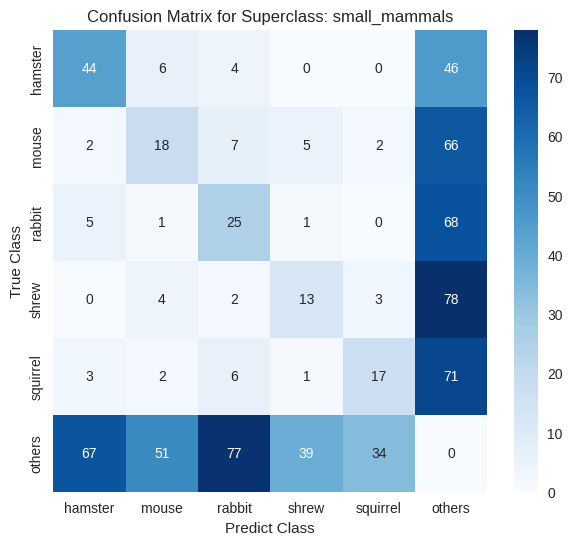

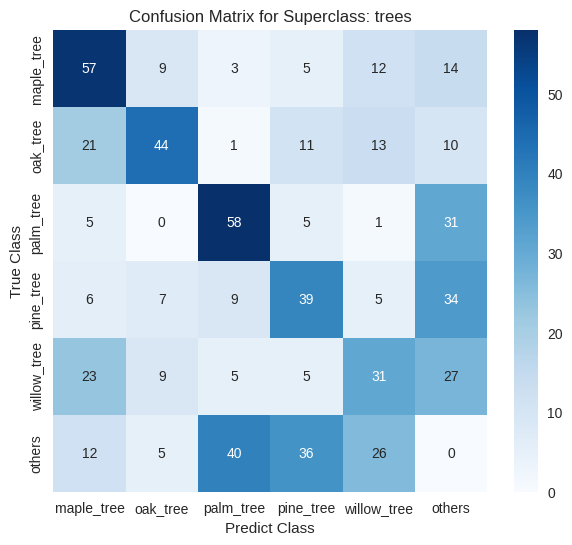

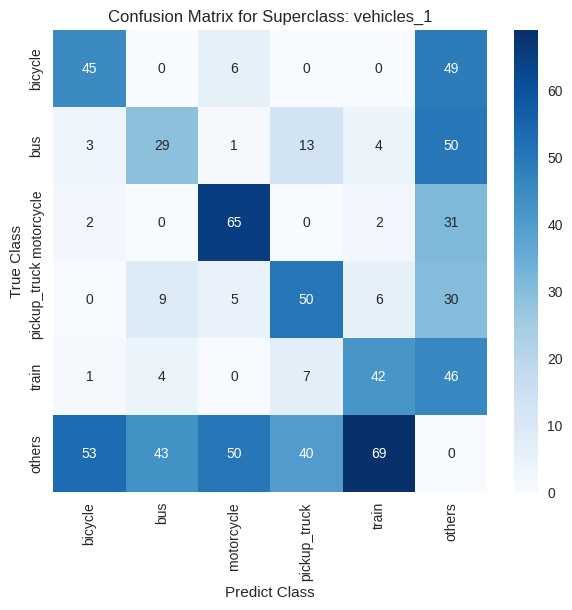

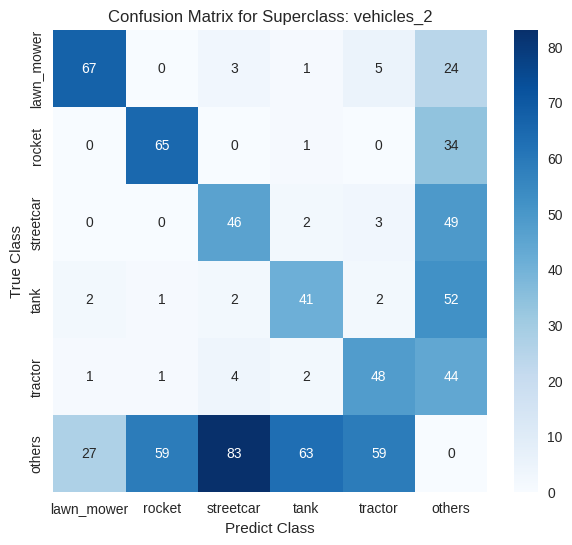

In [16]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [17]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("/kaggle/input/vit_v4/pytorch/default/1/VisionTransformer_CIFAR100_checkpoint (1).pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  35.92 M 
fwd MACs:                                                               76.1882 GMACs
fwd FLOPs:                                                              152.607 GFLOPS
fwd+bwd MACs:                                                           228.565 GMACs
fwd+bwd FLOPs:                                                          457.82 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod